Compare the results of E33 with training classifier and decoder (reco) together. In the latter case accuracy looks much better (~91%, the assumed max from E32).

In [1]:
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

def embed_and_translate(data, nrows, ncols):
    ndata = np.zeros((len(data), nrows, ncols, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
    for i in range(len(data)):
        x = np.random.randint(ncols-width)
        y = np.random.randint(nrows-height)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations
            
n_splits = 16
io_shape = (56,56,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16 * 4 # since we have 4x4-splits we need 4 times the latent space for a fair comparison.

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_augmented, y_train_reco = embed_and_translate(x_train, 56, 56)
x_train_split = np.array([utils.split(x, size, size) for x in x_train_augmented], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_augmented, y_test_reco = embed_and_translate(x_test, 56, 56)
x_test_split = np.array([utils.split(x, size, size) for x in x_test_augmented], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

In [2]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, io_shape):
        super(MultiSplit, self).__init__()
        n_filters = [32, 64]
        size = int( io_shape[0] // (n_splits**(1/2)) )  # W = H
        self.encoder = self._create_encoder(latent_dim//n_splits, (size, size,1), n_filters)
        self.input_reshaper = utils.Reshaper((n_splits, size, size, 1), (size, size,1))
        self.latent_reshaper = utils.Reshaper([latent_dim//n_splits], [latent_dim])
        self.classifier = self._create_classifier(latent_dim)
        self.decoder = self._create_decoder(latent_dim, io_shape, n_filters)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_reco = self.decode(z ,training=training)
        y_class = self.classify(z ,training=training)
        return {"decoder_out": y_reco, "classifier_out": y_class}
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Dense(units=latent_dim, activation='sigmoid')
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * 8),
            Reshape((io_shape[0]//4, io_shape[1]//4, 8)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax')
        ])

1. Givin classification loss of 0.005 (as was done for the 4-split in E27) seems to be too low in the case of 16-split.

In [3]:
losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy'
}
loss_weights = {
    'decoder_out' : 1.0,
    'classifier_out' : 0.005
}
model = MultiSplit(n_splits, latent_dim, io_shape)
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train},
                    validation_data=(x_test_split, {'decoder_out': x_test_augmented, 'classifier_out': y_test}),
                    epochs=25, batch_size=32)

Epoch 1/25
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0276 - classifier_out_loss: 1.9960 - decoder_out_loss: 0.0176 - classifier_out_accuracy: 0.2537 - decoder_out_accuracy: 0.9496 - val_loss: 0.0197 - val_classifier_out_loss: 1.6300 - val_decoder_out_loss: 0.0116 - val_classifier_out_accuracy: 0.4028 - val_decoder_out_accuracy: 0.9463
Epoch 2/25
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0181 - classifier_out_loss: 1.4465 - decoder_out_loss: 0.0108 - classifier_out_accuracy: 0.4804 - decoder_out_accuracy: 0.9470 - val_loss: 0.0165 - val_classifier_out_loss: 1.2838 - val_decoder_out_loss: 0.0101 - val_classifier_out_accuracy: 0.5416 - val_decoder_out_accuracy: 0.9475
Epoch 3/25
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0157 - classifier_out_loss: 1.1690 - decoder_out_loss: 0.0098 - classifier_out_accuracy: 0.5860 - decoder_out_accuracy: 0.9482 - val_loss: 0.0148 - val_classifier_out_loss: 1.0499 - val_decode

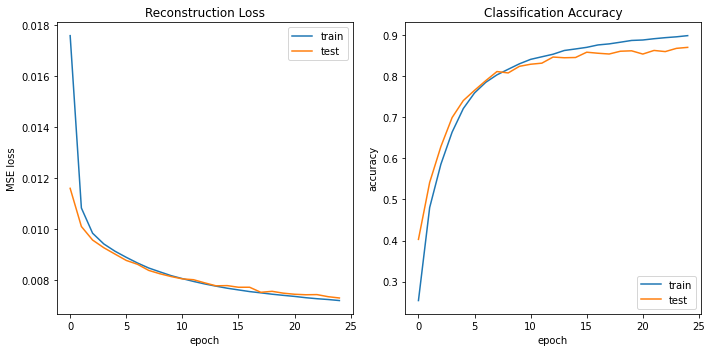

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title('Reconstruction Loss')
axes[0].plot(history.history['decoder_out_loss'])
axes[0].plot(history.history['val_decoder_out_loss'])
axes[0].set_ylabel('MSE loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'test'], loc='upper right')

axes[1].set_title('Classification Accuracy')
axes[1].plot(history.history['classifier_out_accuracy'])
axes[1].plot(history.history['val_classifier_out_accuracy'])
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'test'], loc='lower right')

fig.tight_layout()
# fig.show()
fig.savefig('../img/34/CE4x16_reco1_classify0.005.png')

2. Giving the classification loss double the impact on training seems to be a good choice.

In [3]:
losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy'
}
loss_weights = {
    'decoder_out' : 1.0,
    'classifier_out' : 0.01
}
model = MultiSplit(n_splits, latent_dim, io_shape)
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train},
                    validation_data=(x_test_split, {'decoder_out': x_test_augmented, 'classifier_out': y_test}),
                    epochs=100, batch_size=32)

Epoch 1/100
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0348 - classifier_out_loss: 1.8704 - decoder_out_loss: 0.0161 - classifier_out_accuracy: 0.3050 - decoder_out_accuracy: 0.9490 - val_loss: 0.0260 - val_classifier_out_loss: 1.3935 - val_decoder_out_loss: 0.0121 - val_classifier_out_accuracy: 0.4803 - val_decoder_out_accuracy: 0.9466
Epoch 2/100
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0230 - classifier_out_loss: 1.1136 - decoder_out_loss: 0.0119 - classifier_out_accuracy: 0.6073 - decoder_out_accuracy: 0.9466 - val_loss: 0.0200 - val_classifier_out_loss: 0.8619 - val_decoder_out_loss: 0.0114 - val_classifier_out_accuracy: 0.7077 - val_decoder_out_accuracy: 0.9468
Epoch 3/100
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0188 - classifier_out_loss: 0.7840 - decoder_out_loss: 0.0110 - classifier_out_accuracy: 0.7356 - decoder_out_accuracy: 0.9478 - val_loss: 0.0171 - val_classifier_out_loss: 0.6461 - val_dec

In [4]:
model.encoder.save_weights('../weights/34_CAE4x16_encoder_epoch100.h5')
model.classifier.save_weights('../weights/34_CAE4x16_classifier_head_epoch100.h5')
model.decoder.save_weights('../weights/34_CAE4x16_decoder_head_epoch100.h5')

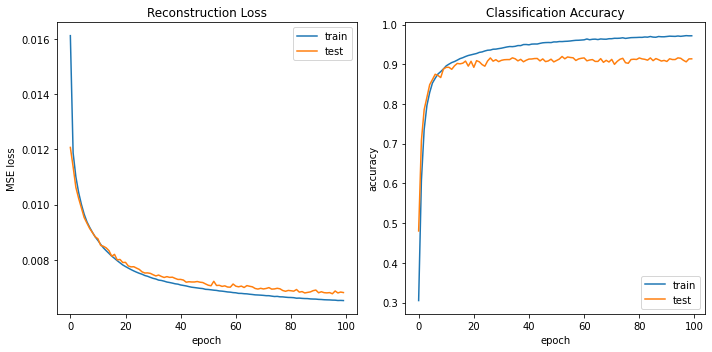

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title('Reconstruction Loss')
axes[0].plot(history.history['decoder_out_loss'])
axes[0].plot(history.history['val_decoder_out_loss'])
axes[0].set_ylabel('MSE loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'test'], loc='upper right')

axes[1].set_title('Classification Accuracy')
axes[1].plot(history.history['classifier_out_accuracy'])
axes[1].plot(history.history['val_classifier_out_accuracy'])
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'test'], loc='lower right')

fig.tight_layout()
# fig.show()
fig.savefig('../img/34/CE4x16_reco1_classify0.01.png')

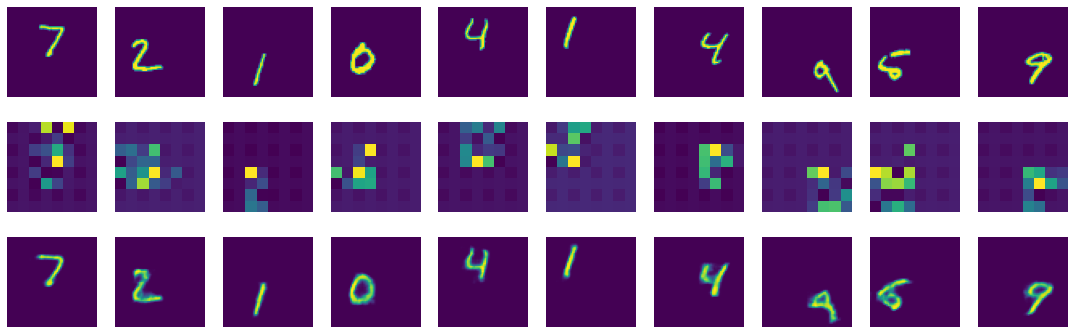

In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf

n = 10
plt.figure(figsize=(19, 6))
for i in range(n):
    
    # predict
    x = x_test_split[i].reshape(1,16,14,14,1)
    z = model.encode(x, training=False)
    y = model.decode(z, training=False)
    
    ax = plt.subplot(3, n, i+1)
    plt.axis('off')
    plt.imshow(x_test_augmented[i].reshape(56,56))
    
    a = np.empty((8,8))
    for j in range(16):
        r = int(j/4)
        c = j%4
        a[r*2:(r+1)*2, c*2:(c+1)*2] = tf.reshape(z[j], (2,2))
    ax = plt.subplot(3, n, n+i+1) 
    plt.axis('off')
    plt.imshow(a)
    
    ax = plt.subplot(3, n, 2*n+i+1) 
    plt.axis('off')
    plt.imshow(tf.reshape(y, (56,56)))

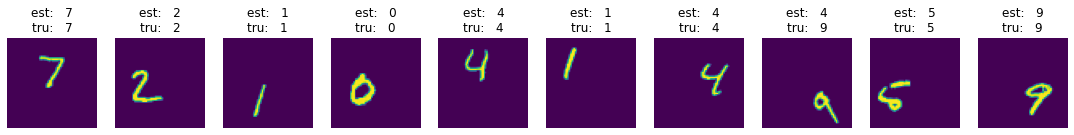

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf

z = model.encode(x_test_split[:1000], training=False)
y = model.classify(z, training=False)
n = 10
plt.figure(figsize=(19, 6))
for i in range(n):
    
    plt.subplot(1,n,i+1)
    plt.axis('off')
    plt.title("est: {:3.0f}\ntru: {:3.0f}".format(np.argmax(y[i]), np.argmax(y_test[i])))
    plt.imshow(x_test_augmented[i].reshape(56,56))